In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

save_folder = "gd1_tail"

import logging
logging.basicConfig(filename=save_folder+'/log.log', level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

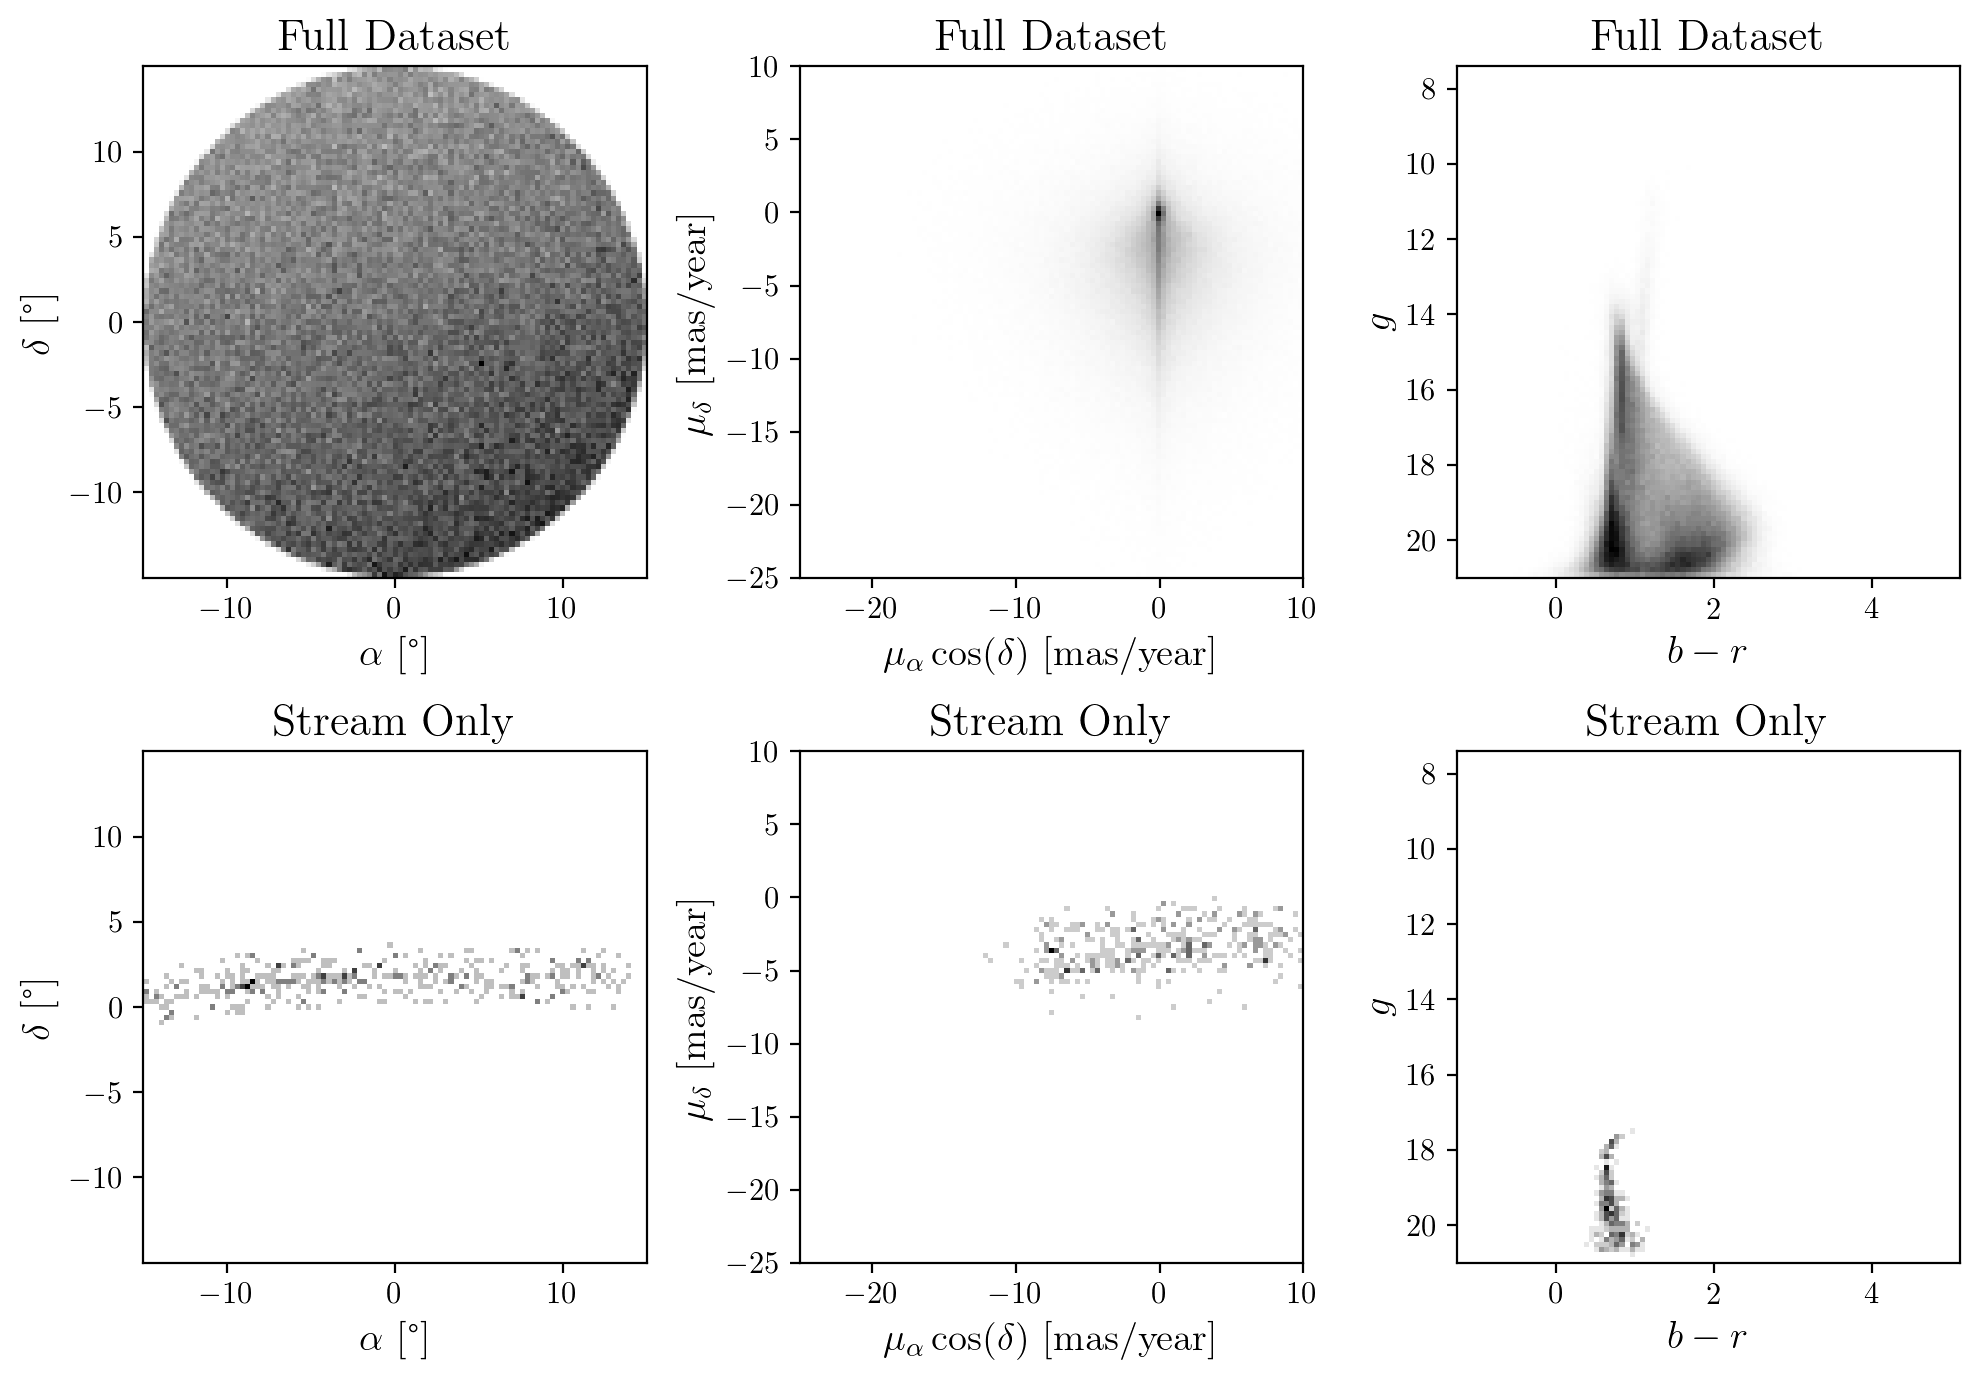

In [3]:
stream = "gd1_tail"
logging.info("Stream = "+stream)
df, file = load_file(stream = stream)
plot_coords(df, save_folder = save_folder)

SR factor: 1
SB factor: 3
Sideband region: [-7.8,-4.9) & (-2.1,0.8]
Signal region: [-4.9,-2.1]
Total counts: SR = 141,621, SB = 226,490
Signal region has 261 stream and 141,360 bkg events (0.18%).
Sideband region has 393 stream and 367,718 bkg events (0.11%).
f_sig = 1.7X f_sideband.


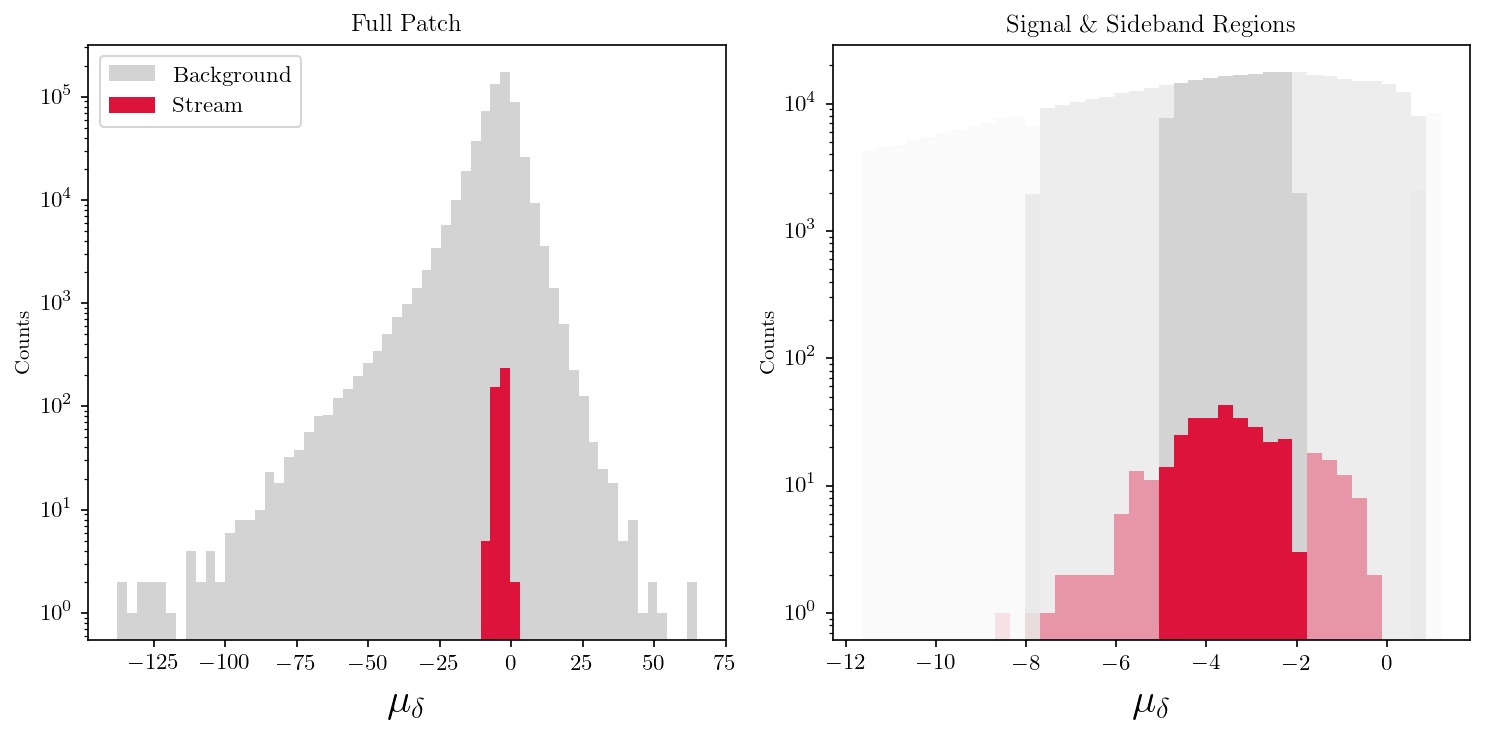

In [4]:
sr_factor = 1
sb_factor = 3 
logging.info("Signal Region scale factor = "+str(sr_factor))
logging.info("Sideband Region scale factor = "+str(sb_factor))
df_slice = signal_sideband(df, sr_factor = sr_factor, sb_factor=sb_factor, stream = stream, save_folder = save_folder)

# Train

In [5]:
print("Dataframe has {:,} stars, of which {:,} are stream stars.".format(
    len(df_slice), 
    len(df_slice[df_slice.stream])))

Dataframe has 368,111 stars, of which 393 are stream stars.


[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]2022-12-19 11:37:51.663432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 11:37:52.407433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39775 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-12-19 11:37:54.307685: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:51<02:34, 51.57s/it]

2301/2301 [==============================] - 2s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:37<01:35, 47.98s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:20<00:45, 45.79s/it]

2301/2301 [==============================] - 2s 837us/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:42<02:08, 42.88s/it]

2301/2301 [==============================] - 2s 863us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:25<01:25, 42.94s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:10<00:43, 43.73s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

2301/2301 [==============================] - 2s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:43<02:11, 43.74s/it]

2301/2301 [==============================] - 2s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:26<01:25, 42.95s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:09<00:43, 43.26s/it]

2301/2301 [==============================] - 2s 900us/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:43<02:11, 43.71s/it]

2301/2301 [==============================] - 2s 852us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:26<01:26, 43.27s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:08<00:42, 42.81s/it]

2301/2301 [==============================] - 2s 796us/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:43<02:09, 43.17s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:27<01:27, 43.66s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:10<00:43, 43.29s/it]

2301/2301 [==============================] - 3s 1ms/step



[Step 1] k-fold: 100%|██████████| 5/5 [14:43<00:00, 176.66s/it]


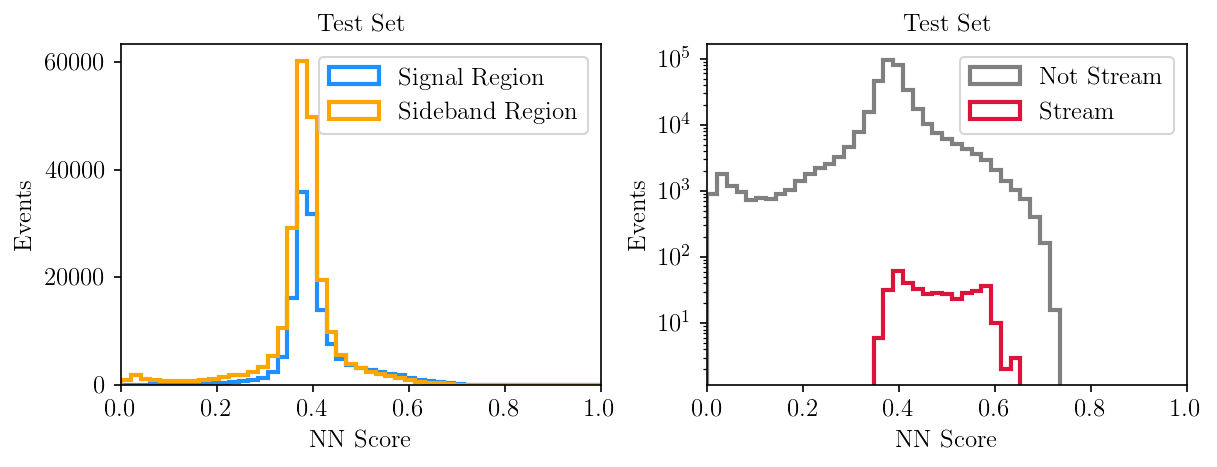

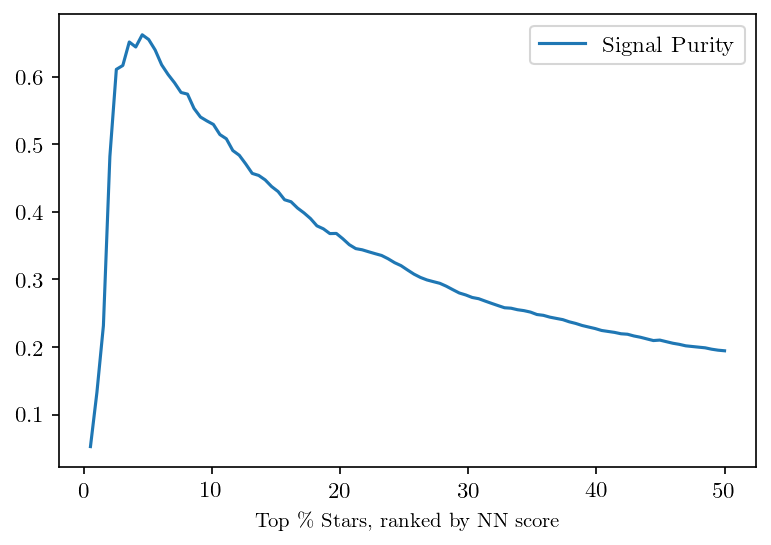

Top 50 stars: Purity = 0.0% 


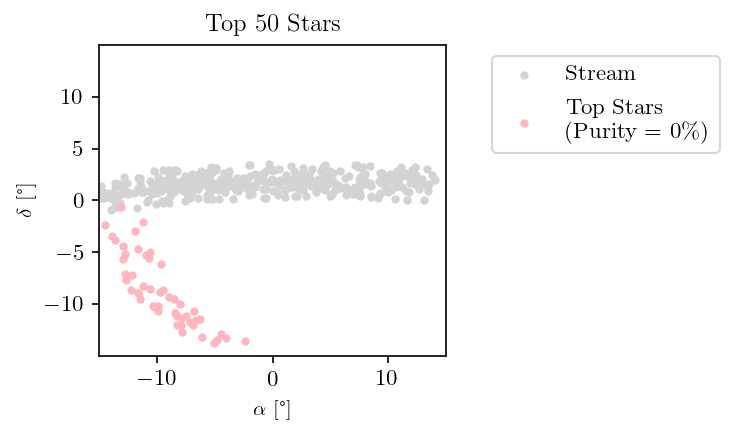

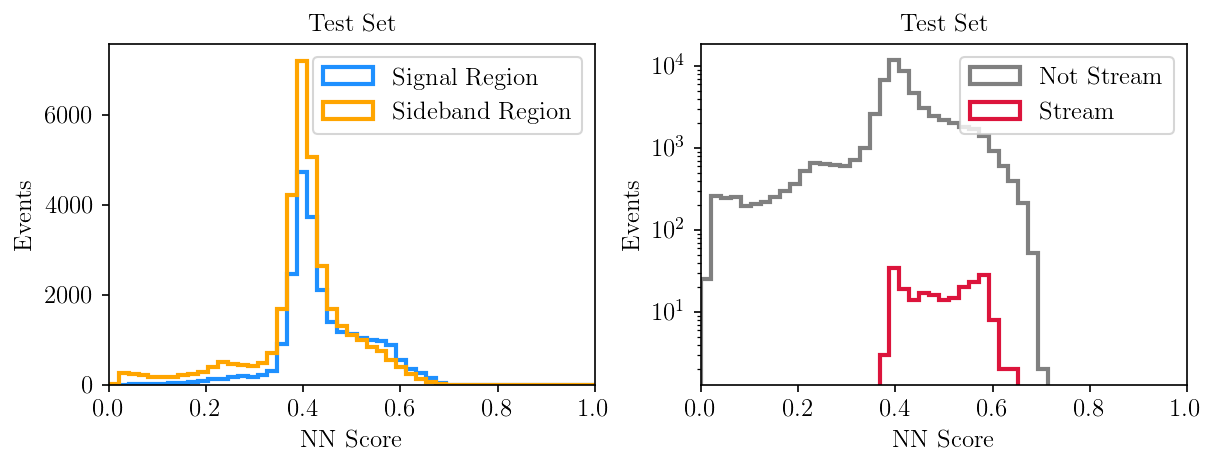

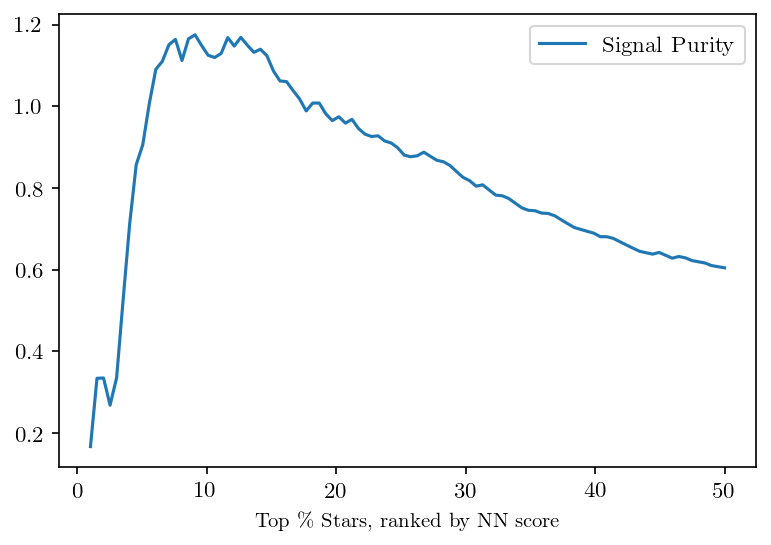

Top 50 stars: Purity = 0.0% 


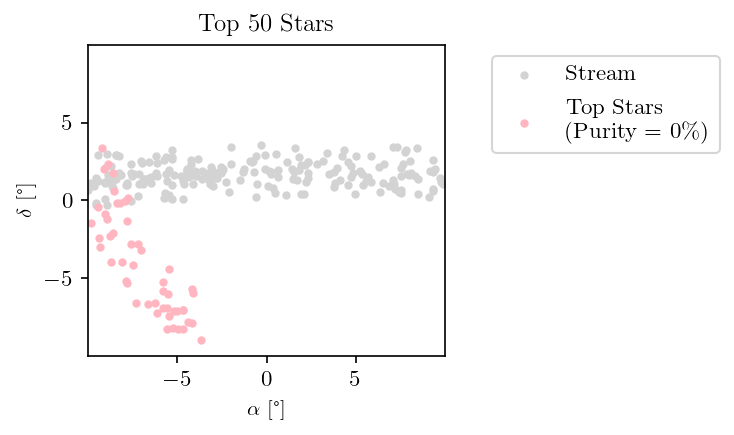

In [6]:
tf.keras.backend.clear_session()
df_test = train(df_slice, 
#       n_folds = 5, 
#       best_of_n_loops = 3,
#       layer_size = 50, 
#       batch_size = 10000, 
#       dropout = 0.2, 
#       epochs = 1000, 
#       patience = 20,
      verbose = False,
      save_folder = save_folder, 
                        )